In [ ]:
from google.colab import files, drive
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import *
import zipfile
from tensorflow import keras
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Kaggle API

In [ ]:
#you need to create your own API first in kaggle
#upload kaggle json

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felixpratama","key":"a3f1e3c240e43be127334f9fe19c9a0e"}'}

In [ ]:
#create a kaggle folder
!mkdir ~/.kaggle

In [ ]:
#copy kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d preatcher/standard-ocr-dataset

 56% 26.0M/46.2M [00:00<00:00, 135MB/s] 
100% 46.2M/46.2M [00:00<00:00, 167MB/s]


# Load Image

In [ ]:
test_local_zip = '/content/standard-ocr-dataset.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/dataset')

zip_ref.close()

In [ ]:
os.listdir('/tmp/dataset')

['data', 'data2']

In [ ]:
source_dir = '/tmp/dataset/data'
os.listdir(source_dir)

['training_data', 'testing_data']

In [ ]:
training_data_dir = os.path.join(source_dir, 'training_data')
validation_data_dir = os.path.join(source_dir, 'testing_data')

In [ ]:
print('len of folders in training data dir: {}'.format(len(os.listdir(training_data_dir))))
print('len of folders in validation data dir: {}'.format(len(os.listdir(validation_data_dir))))

len of folders in training data dir: 36
len of folders in validation data dir: 36


In [ ]:
k = os.listdir(training_data_dir)[0]
k = os.path.join(training_data_dir, k)

In [ ]:
print(k)

/tmp/dataset/data/training_data/G


In [ ]:
k_img = []
for index in range (len(k)):
  img = cv2.imread(os.path.join(k, os.listdir(k)[index]))
  k_img.append(img)

In [ ]:
k_img[0].shape

(39, 27, 3)

# Preprocessing Image

In [ ]:
# ret,thresh1 = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)
# kernel = np.ones((5,5),np.uint8)
# dilated = cv2.dilate(thresh1,kernel,iterations = 2)
# _,contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# cordinates = []
# for cnt in contours:
#     x,y,w,h = cv2.boundingRect(cnt)
#     cordinates.append((x,y,w,h))
#     #bound the images
#     cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),1)

# cv2.namedWindow('BindingBox', cv2.WINDOW_NORMAL)
# cv2.imwrite('content/BindingBox4.jpg',im)

In [ ]:
img_size = 128
input_shape = (128,128,1)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

training_generator = train_datagen.flow_from_directory(training_data_dir,
                                                 target_size = (img_size, img_size),
                                                 batch_size = 382,  # 20628 // 54 = 382
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical',
    
)

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                 target_size = (img_size, img_size),
                                                 batch_size = 36, #1008 // 28 = 36 
                                                 color_mode = 'grayscale',
                                                 class_mode = 'categorical',
    
)

Found 20628 images belonging to 36 classes.
Found 1008 images belonging to 36 classes.


# Train Model

In [ ]:
#make a model

# callback = EarlyStopping(monitor = 'val_loss',
#                         patience = 3,
#                         verbose = 1) 


model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32,(5,5), activation ='relu', input_shape=input_shape), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Dense(256, activation = 'relu'),
      tf.keras.layers.Dense(36, activation='softmax'),



])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(training_generator,
                            steps_per_epoch = 54,
                            epochs = 100,
                            validation_data = validation_generator,
                            validation_steps = 28,
                            verbose = 2)

Epoch 1/100
54/54 - 58s - loss: 2.9135 - accuracy: 0.1880 - val_loss: 1.1405 - val_accuracy: 0.6518 - 58s/epoch - 1s/step
Epoch 2/100
54/54 - 43s - loss: 1.4817 - accuracy: 0.5514 - val_loss: 0.4179 - val_accuracy: 0.8968 - 43s/epoch - 787ms/step
Epoch 3/100
54/54 - 42s - loss: 0.9919 - accuracy: 0.7044 - val_loss: 0.2662 - val_accuracy: 0.9325 - 42s/epoch - 787ms/step
Epoch 4/100
54/54 - 43s - loss: 0.7738 - accuracy: 0.7702 - val_loss: 0.1890 - val_accuracy: 0.9435 - 43s/epoch - 789ms/step
Epoch 5/100
54/54 - 42s - loss: 0.6591 - accuracy: 0.8068 - val_loss: 0.2050 - val_accuracy: 0.9315 - 42s/epoch - 784ms/step
Epoch 6/100
54/54 - 42s - loss: 0.5790 - accuracy: 0.8297 - val_loss: 0.1339 - val_accuracy: 0.9573 - 42s/epoch - 786ms/step
Epoch 7/100
54/54 - 42s - loss: 0.5293 - accuracy: 0.8438 - val_loss: 0.2073 - val_accuracy: 0.9167 - 42s/epoch - 787ms/step
Epoch 8/100
54/54 - 42s - loss: 0.4852 - accuracy: 0.8559 - val_loss: 0.1015 - val_accuracy: 0.9623 - 42s/epoch - 784ms/step
Epo

In [ ]:
!mkdir -p ocr_model
model.save('/content/ocr-model-Felix-3.h5')

In [ ]:
# my_model directory
!ls ocr_model

# # Contains an assets folder, saved_model.pb, and variables folder.
# !ls saved_model/my_model

ocr-model-Felix-1.h5


In [ ]:
model = tf.keras.models.load_model('/content/ocr-model-Felix-3.h5')

# Predict

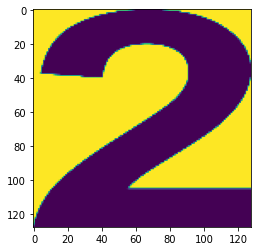


predict: 2


In [ ]:
img = cv2.imread("/content/2-transparent-35377.png")
img = cv2.resize(img, (128,128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()

img = np.array(img, dtype = 'float32')
img = np.expand_dims(img, axis = 2)
img = img.reshape(-1, 128, 128, 1)
prediction = model.predict(img)
np.argmax(prediction)

labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
print("\npredict: {}".format(labelNames[np.argmax(prediction)]))

In [ ]:
# labelNames = "0123456789"

# labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# labelNames = [l for l in labelNames]

# predictions = model.predict('/content/2-transparent-35377.png')

# print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))


In [ ]:
# img = cv2.imread("/content/download (1).png")
# # img - np.invert(np.array([img]))
# prediction = model.predict(img)
# print(np.argmax(prediction))